In [99]:
#%pip install seaborn
#%pip install pandas
#%pip install numpy
#%pip install zipfile
import requests
import pandas as pd
import numpy as np
import datetime
import os
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [100]:
#List of countries and regions are here: https://unstats.un.org/unsd/methodology/m49/overview/ but website using
#javascript and not providing link for csv file directly
#Workaround:
#Using a github page to download a csv file
url = "https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/raw/master/all/all.csv"
filename = "countries.csv"

response = requests.get(url)

if response.status_code == 200:
    with open(filename, "wb") as file:
        file.write(response.content)
    print("CSV file downloaded successfully.")
else:
    print("Failed to download the CSV file.")

CSV file downloaded successfully.


In [101]:
df_countries=pd.read_csv("countries.csv")

In [102]:
#To find a file of your interest: https://data.worldbank.org/indicator
#Clicking on a subset allows to get address to download csv-file

#These are addresses to obtain the data for GDP per capita, life expectancy and literacy rate
url_list=["https://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.PP.CD?downloadformat=csv", \
          "https://api.worldbank.org/v2/en/indicator/SP.DYN.LE00.IN?downloadformat=csv",\
            "https://api.worldbank.org/v2/en/indicator/SE.ADT.LITR.ZS?downloadformat=csv"]

In [103]:
#Also, giving names for the data to be obtained
data_list=["gdp_per_capita", "life_expectancy", "literacy"]

In [104]:
#First, making folder to download the data from web, names based on data_list
for d in data_list:
    if not os.path.exists(d):
        os.makedirs(d)
    if not os.path.exists(d+"_unpacked"):
        os.makedirs(d+"_unpacked")

In [105]:
#Here one by one, I dowload the data and put into a right folder
for d, u in zip(data_list, url_list):
    response = requests.get(u)
    if response.status_code == 200:
        with open(d+"/"+d+".zip", "wb") as file:
            file.write(response.content)
        print("Zip file downloaded successfully!")
    else:
        print("Failed to retrieve the zip file.")

Zip file downloaded successfully!
Zip file downloaded successfully!
Zip file downloaded successfully!


In [106]:
#Unpacking the data as well
for d in data_list:
    zip_file_path=d+"/"+d+".zip"
    destination_folder=d+"_unpacked"
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)
    print("Extraction completed!")


Extraction completed!
Extraction completed!
Extraction completed!


In [107]:
#To remove excess rows in the csv file, an additional method:
def copy_file(source_file, destination_file):
    with open(source_file, 'r') as source:
        with open(destination_file, 'w') as destination:
            counter=0
            for line in source:
                if(counter>3):
                    destination.write(line)
                counter=counter+1

In [108]:
#Removing extra rows from the csv file:
for d in data_list:
    file_list=os.listdir(d+"_unpacked")
    file_list.sort()
    source_file=d+"_unpacked/"+file_list[0]
    destination_file=d+".csv"
    copy_file(source_file, destination_file)

In [109]:
#Using pandas, going to create the dataframe list:
df_list=[]
for d in data_list:
    temp_df=pd.read_csv(d+".csv")
    df_list.append(temp_df)

In [110]:
#The last column is empty, must be removed
df_list[0].head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,36846.848285,37343.912963,37583.840323,38865.188195,41679.238190,42501.641554,34971.009913,42698.359872,NaN,NaN
1,Africa Eastern and Southern,AFE,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3470.550675,3498.125396,3591.099809,3635.564622,3724.868177,3777.972368,3621.058106,3839.470058,NaN,NaN
2,Afghanistan,AFG,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2110.829568,2128.125938,2023.834656,2096.093111,2109.929296,2167.704111,2076.138380,1665.805842,NaN,NaN
3,Africa Western and Central,AFW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4143.177054,4075.994459,3998.951876,4045.303263,4160.540965,4264.731035,4174.504565,4409.450961,NaN,NaN
4,Angola,AGO,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8123.048065,7274.090475,7027.146634,7216.061373,7042.923829,6881.076241,6362.636076,6491.125578,NaN,NaN


In [111]:
#Running the deletion
for n in range(len(df_list)):
    df_list[n]=df_list[n][df_list[n].columns[:-2]]

In [112]:
#Checking
df_list[0].head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,34786.593993,36932.184164,36846.848285,37343.912963,37583.840323,38865.188195,41679.238190,42501.641554,34971.009913,42698.359872
1,Africa Eastern and Southern,AFE,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3208.016619,3333.520911,3470.550675,3498.125396,3591.099809,3635.564622,3724.868177,3777.972368,3621.058106,3839.470058
2,Afghanistan,AFG,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1958.447627,2062.059176,2110.829568,2128.125938,2023.834656,2096.093111,2109.929296,2167.704111,2076.138380,1665.805842
3,Africa Western and Central,AFW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3801.052234,3950.948889,4143.177054,4075.994459,3998.951876,4045.303263,4160.540965,4264.731035,4174.504565,4409.450961
4,Angola,AGO,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,7389.314960,7643.921944,8123.048065,7274.090475,7027.146634,7216.061373,7042.923829,6881.076241,6362.636076,6491.125578


In [113]:
#Here I extract regions and sub-region from countries file and renaming a column
df_countries_small=df_countries[["name","region","sub-region"]]
df_countries_small = df_countries_small.rename(columns={'name': 'Country Name'})

In [114]:
#Conducting merge on country names
#For gdp per capita
df_gdppcap=df_countries_small.merge(df_list[0], on='Country Name', how='inner')
#For life expectancy
df_lifeexp=df_countries_small.merge(df_list[1], on='Country Name', how='inner')
#For literacy
df_literacy=df_countries_small.merge(df_list[2], on='Country Name', how='inner')
##These are the dataframes one can work now!


In [115]:
#Here saving dataframes as csv files for PowerBI
#These are time-series
if not os.path.exists('ForPowerBI'):
    os.makedirs('ForPowerBI')
df_gdppcap.to_csv('ForPowerBI/df_gdppcap.csv')
df_lifeexp.to_csv('ForPowerBI/df_lifeexp.csv')
df_literacy.to_csv('ForPowerBI/df_literacy.csv')

In [116]:
#To get literacy values for year 2021, replacing NaN with np.nan
df_literacy=df_literacy.replace('NaN',np.nan)
#Filling np.nan with closest value to the left
df_literacy=df_literacy.ffill(axis=1)
df_literacy.head()

,Country Name,region,sub-region,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Afghanistan,Asia,Southern Asia,AFG,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,...,31.448851,31.448851,31.448851,31.448851,31.448851,31.448851,31.448851,31.448851,31.448851,37.266041
1,Albania,Europe,Southern Europe,ALB,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,...,97.246971,97.246971,97.246971,97.246971,97.246971,97.246971,98.141151,98.141151,98.141151,98.449997
2,Algeria,Africa,Northern Africa,DZA,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,...,75.136047,75.136047,75.136047,75.136047,75.136047,75.136047,81.407837,81.407837,81.407837,81.407837
3,American Samoa,Oceania,Polynesia,ASM,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,...,97.344162,97.344162,97.344162,97.344162,97.344162,97.344162,97.344162,97.344162,97.344162,97.344162
4,Andorra,Europe,Southern Europe,AND,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,...,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS,SE.ADT.LITR.ZS


In [117]:
#Getting values to year 2021
df_literacy_2021=df_literacy[['Country Name','region','sub-region','2021']]
df_literacy_2021.head()

,Country Name,region,sub-region,2021
0,Afghanistan,Asia,Southern Asia,37.266041
1,Albania,Europe,Southern Europe,98.449997
2,Algeria,Africa,Northern Africa,81.407837
3,American Samoa,Oceania,Polynesia,97.344162
4,Andorra,Europe,Southern Europe,SE.ADT.LITR.ZS


In [118]:
#One more change-removing these rows, where literacy could not be extrapolated
df_literacy_2021=df_literacy_2021[pd.to_numeric(df_literacy_2021['2021'], errors='coerce').notna()]
df_literacy_2021.head()

,Country Name,region,sub-region,2021
0,Afghanistan,Asia,Southern Asia,37.266041
1,Albania,Europe,Southern Europe,98.449997
2,Algeria,Africa,Northern Africa,81.407837
3,American Samoa,Oceania,Polynesia,97.344162
5,Angola,Africa,Sub-Saharan Africa,72.279999


In [119]:
#Getting gdp per capita for 2021
#To get literacy values for year 2021, replacing NaN with np.nan
df_gdppcap=df_gdppcap.replace('NaN',np.nan)
#Getting for year 2021
df_gdppcap_2021=df_gdppcap[['Country Name','2021']]
#Removing these rows, where np.nan
df_gdppcap_2021=df_gdppcap_2021.dropna()

In [120]:
#Merging gdppcap_2021 with literacy_2021
df_gdppcap_literacy_2021=df_literacy_2021.merge(df_gdppcap_2021, on='Country Name', how='inner')
df_gdppcap_literacy_2021.head()


,Country Name,region,sub-region,2021_x,2021_y
0,Afghanistan,Asia,Southern Asia,37.266041,1665.805842
1,Albania,Europe,Southern Europe,98.449997,15814.411571
2,Algeria,Africa,Northern Africa,81.407837,12128.274991
3,Angola,Africa,Sub-Saharan Africa,72.279999,6491.125578
4,Antigua and Barbuda,Americas,Latin America and the Caribbean,98.949997,21010.003574


In [121]:
df_gdppcap_literacy_2021 = df_gdppcap_literacy_2021.rename(columns={'2021_x': 'Literacy', '2021_y':'GDPPCAP'})
df_gdppcap_literacy_2021.head()

,Country Name,region,sub-region,Literacy,GDPPCAP
0,Afghanistan,Asia,Southern Asia,37.266041,1665.805842
1,Albania,Europe,Southern Europe,98.449997,15814.411571
2,Algeria,Africa,Northern Africa,81.407837,12128.274991
3,Angola,Africa,Sub-Saharan Africa,72.279999,6491.125578
4,Antigua and Barbuda,Americas,Latin America and the Caribbean,98.949997,21010.003574


[Text(0.5, 1.0, 'GDP per Capita vs Literacy in 2021')]

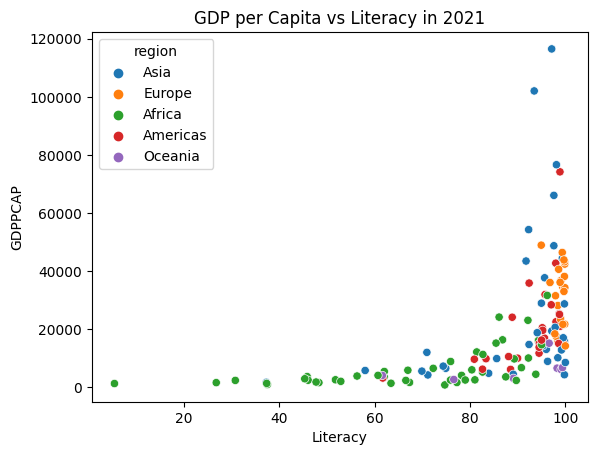

In [122]:
sns.scatterplot(x="Literacy",
                    y="GDPPCAP",
                    data=df_gdppcap_literacy_2021, hue='region').set(title='GDP per Capita vs Literacy in 2021')

In [123]:
#Also that to csv file
df_gdppcap_literacy_2021.to_csv('ForPowerBI/df_gdppcap_literacy_2021.csv')

In [124]:
#Here I want to extract only country and values for each year
#Extract years from column names
years=list(df_gdppcap.columns)[6:]
#A trick to add 'Country name' as a wanted column
Country=['Country Name']
#Extraction itself
df_gdppcap_country=df_gdppcap[Country+years]

In [125]:
#Checking progress
df_gdppcap_country.head()

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1958.447627,2062.059176,2110.829568,2128.125938,2023.834656,2096.093111,2109.929296,2167.704111,2076.138380,1665.805842
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10526.250106,10570.966045,11259.303681,11658.894897,12078.799334,12770.987862,13498.196119,14407.460749,14035.354780,15814.411571
2,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13347.362795,13104.737104,13058.124574,12071.814181,11685.451418,11809.483033,12006.010238,12118.004500,11438.691156,12128.274991
3,American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
df_gdppcap_country=df_gdppcap_country.dropna(subset=years, how='all')

In [127]:
#Also making a dataframe for sub-regions and taking average for each year
df_gdppcap_subregion=df_gdppcap.groupby(['sub-region'])[years].mean().reset_index()


In [128]:
#Such process would necessary for lineplot, melting
df_gdppcap_subregion.melt(id_vars=['sub-region'])

,sub-region,variable,value
0,Australia and New Zealand,1960,NaN
1,Central Asia,1960,NaN
2,Eastern Asia,1960,NaN
3,Eastern Europe,1960,NaN
4,Latin America and the Caribbean,1960,NaN
...,...,...,...
1049,Southern Asia,2021,9083.074522
1050,Southern Europe,2021,31544.496640
1051,Sub-Saharan Africa,2021,5823.328401
1052,Western Asia,2021,37677.149857


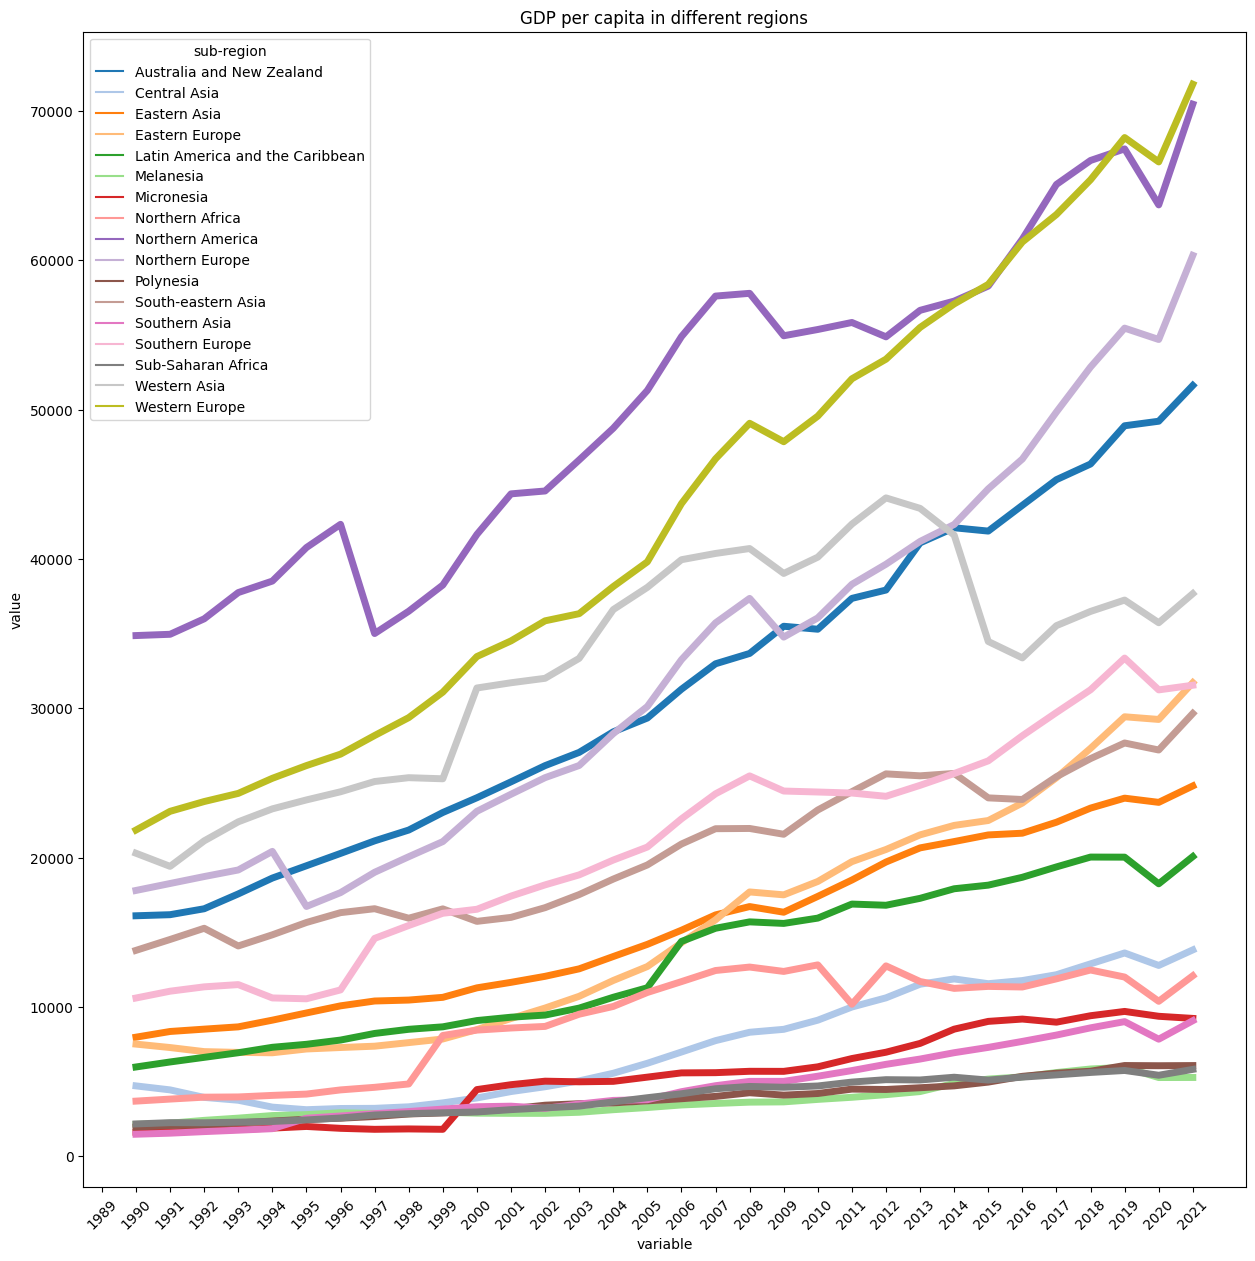

In [129]:
#The dataframe has to be melted
plt.figure(figsize=(15, 15))

sns.lineplot(data=df_gdppcap_subregion.melt(id_vars=['sub-region']), 
             x='variable', y='value', hue='sub-region', palette='tab20',lw=5).set(title='GDP per capita in different regions')

plt.xticks(rotation=45)

#No extra text as output, thus 'None' needed
None


In [130]:
#Also that to csv
df_gdppcap_subregion.to_csv('ForPowerBI/df_gdppcap_subregion.csv')

In [131]:
#Separate table for regions
gdp_per_capita_df = df_list[0]
regions_gdp_df = df_list[0].loc[gdp_per_capita_df['Country Name'].isin(["Africa Eastern and Southern",\
                                    "Africa Western and Central",\
                                    "Arab World",\
                                    "Central Europe and the Baltics",\
                                    "Caribbean small states",\
                                    "East Asia & Pacific (excluding high income)",\
                                    "East Asia & Pacific",\
                                    "Europe & Central Asia (excluding high income)",\
                                    "Europe & Central Asia",\
                                    "European Union",\
                                    "Latin America & Caribbean (excluding high income)",\
                                    "Latin America & Caribbean",\
                                    "Middle East & North Africa",\
                                    "Middle East & North Africa (excluding high income)",\
                                    "North America",\
                                    "Sub-Saharan Africa (excluding high income)",\
                                    "Sub-Saharan Africa"])]
regions_gdp_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1,Africa Eastern and Southern,AFE,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3208.016619,3333.520911,3470.550675,3498.125396,3591.099809,3635.564622,3724.868177,3777.972368,3621.058106,3839.470058
3,Africa Western and Central,AFW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3801.052234,3950.948889,4143.177054,4075.994459,3998.951876,4045.303263,4160.540965,4264.731035,4174.504565,4409.450961
7,Arab World,ARB,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,15849.100144,15786.576081,15565.992148,14055.953265,13594.676481,14052.546913,14463.364253,14634.455952,13914.583485,14793.881313
36,Central Europe and the Baltics,CEB,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,23102.244671,23855.330206,24922.477098,26130.663011,27749.202828,29826.242741,32000.758785,34934.337770,34762.171670,37579.797677
49,Caribbean small states,CSS,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,15475.815425,15713.674950,15957.916650,15725.925036,15493.716922,16175.340527,16645.404967,17049.114651,15873.377116,17323.612263


In [132]:
regions_gdp_df.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'],
      dtype='object')

In [133]:
regions_gdp_2021_df = regions_gdp_df[['Country Name', '2021']].reset_index(drop=True)
regions_gdp_2021_df.rename(columns = {'Country Name' : 'Region', '2021':'GDPPCAP'}, inplace = True)
regions_gdp_2021_df

,Region,GDPPCAP
0,Africa Eastern and Southern,3839.470058
1,Africa Western and Central,4409.450961
2,Arab World,14793.881313
3,Central Europe and the Baltics,37579.797677
4,Caribbean small states,17323.612263
5,East Asia & Pacific (excluding high income),16894.577910
6,East Asia & Pacific,20249.846275
7,Europe & Central Asia (excluding high income),24980.915628
8,Europe & Central Asia,39231.636464
9,European Union,48779.382436


In [134]:
#Getting life expectancy for years, where we have values
life_expectancy_df = df_list[1]
life_expectancy_df2 = life_expectancy_df.drop(['Indicator Code', '1960', '1961',
       '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970',
       '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
       '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989'], axis=1)

In [135]:
life_expectancy_2021_df=life_expectancy_df2[['Country Name', '2021']].reset_index(drop=True)
life_expectancy_2021_df.rename(columns = {'Country Name' : 'Region', '2021':'Life expectancy'}, inplace = True)
life_expectancy_2021_df

,Region,Life expectancy
0,Aruba,74.626000
1,Africa Eastern and Southern,62.454585
2,Afghanistan,61.982000
3,Africa Western and Central,56.988657
4,Angola,61.643000
...,...,...
261,Kosovo,76.806000
262,"Yemen, Rep.",63.753000
263,South Africa,62.341000
264,Zambia,61.223000


In [136]:
#Joining tables together
life_expectancy_GDPCAP_df=life_expectancy_2021_df.merge(regions_gdp_2021_df, on='Region', how='inner')
life_expectancy_GDPCAP_df

,Region,Life expectancy,GDPPCAP
0,Africa Eastern and Southern,62.454585,3839.470058
1,Africa Western and Central,56.988657,4409.450961
2,Arab World,70.814483,14793.881313
3,Central Europe and the Baltics,74.932414,37579.797677
4,Caribbean small states,70.996259,17323.612263
5,East Asia & Pacific (excluding high income),75.543291,16894.577910
6,East Asia & Pacific,76.393934,20249.846275
7,Europe & Central Asia (excluding high income),71.433174,24980.915628
8,Europe & Central Asia,76.631526,39231.636464
9,European Union,80.387131,48779.382436


<Axes: xlabel='Life expectancy', ylabel='GDPPCAP'>

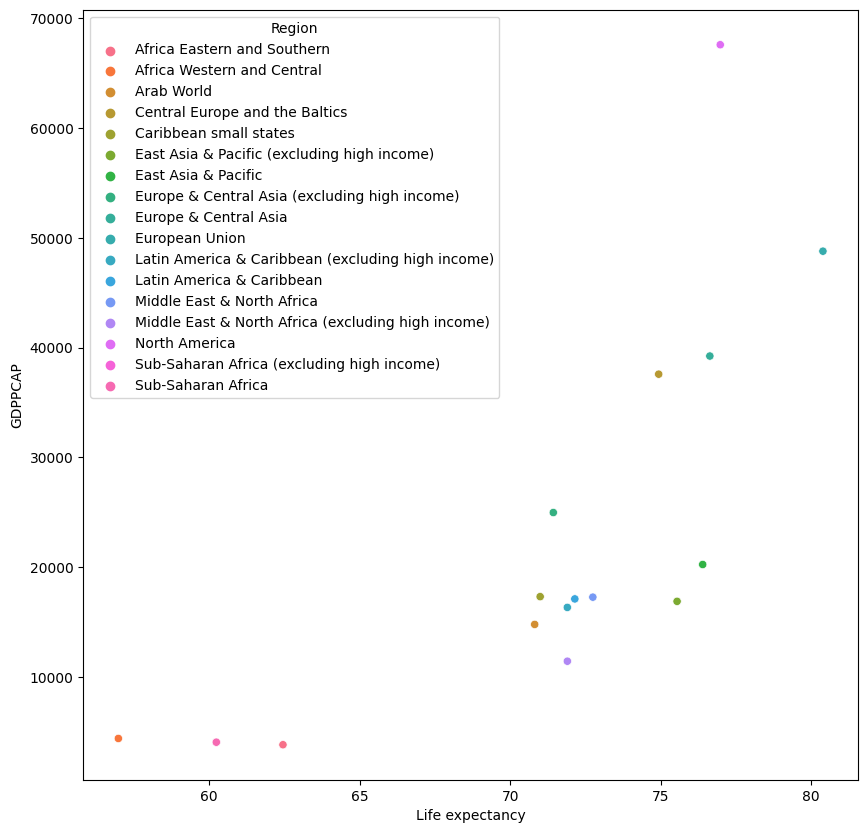

In [137]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=life_expectancy_GDPCAP_df, x='Life expectancy', y='GDPPCAP', hue='Region')

In [138]:
#Also that as csv file:
life_expectancy_GDPCAP_df.to_csv('ForPowerBI/life_expectancy_GDPCAP_df.csv')

In [139]:
#The same as above, but for individual countries
df_gdppcap=df_countries_small.merge(df_list[0], on='Country Name', how='inner')
#For life expectancy
df_lifeexp=df_countries_small.merge(df_list[1], on='Country Name', how='inner')

In [140]:
df_gdppcap_2021=df_gdppcap[['Country Name','2021']].dropna()
df_gdppcap_2021 = df_gdppcap_2021.rename(columns={'2021': 'GDPPCAP'})
df_lifeexp_2021=df_lifeexp[['Country Name','region','2021']].dropna()
df_lifeexp_2021 = df_lifeexp_2021.rename(columns={'2021': 'Life expectancy'})


In [141]:
df_lifeexp_gdpcap_2021=df_lifeexp_2021.merge(df_gdppcap_2021, on='Country Name', how='inner')
df_lifeexp_gdpcap_2021.head()

,Country Name,region,Life expectancy,GDPPCAP
0,Afghanistan,Asia,61.982,1665.805842
1,Albania,Europe,76.463,15814.411571
2,Algeria,Africa,76.377,12128.274991
3,Angola,Africa,61.643,6491.125578
4,Antigua and Barbuda,Americas,78.497,21010.003574


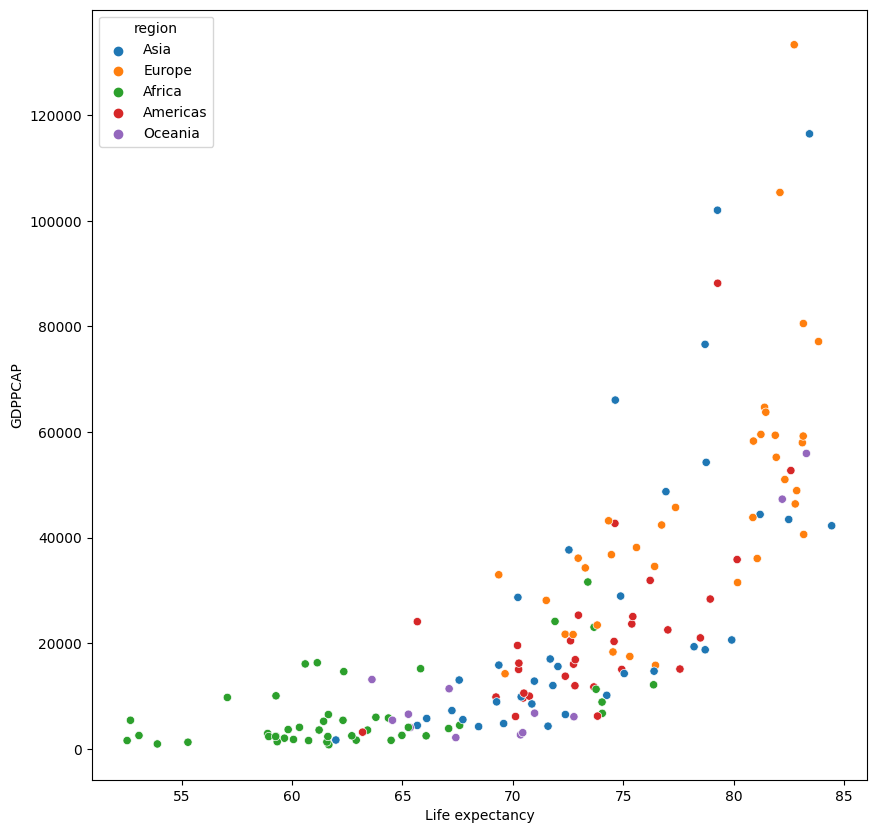

In [142]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_lifeexp_gdpcap_2021, x='Life expectancy', y='GDPPCAP', hue='region')
None

In [143]:
df_lifeexp_gdpcap_2021.to_csv('ForPowerBI/df_lifeexp_gdpcap_2021.csv')

In [144]:
#Now going to extract data for Estonia
df_gdppcap_estonia=df_gdppcap.loc[df_gdppcap['Country Name'] == 'Estonia']

In [145]:
df_gdppcap_estonia.head()

,Country Name,region,sub-region,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
53,Estonia,Europe,Northern Europe,EST,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,...,25996.046778,27464.518678,28945.46533,29175.925927,31312.7523,33821.932908,36249.358146,38961.597443,38536.458081,42391.730055


In [146]:
#Extract years from column names, 1995-2021
years=list(df_gdppcap.columns)[-27:]


In [147]:
estonia_gdppcap=df_gdppcap_estonia[years].values.flatten().tolist()            

In [148]:
df_lifeexp_estonia=df_lifeexp.loc[df_lifeexp['Country Name'] == 'Estonia']

In [149]:
estonia_lifeexp=df_lifeexp_estonia[years].values.flatten().tolist()

In [150]:
est={'Year':years, 'GDPPCAP':estonia_gdppcap, 'Life expectancy':estonia_lifeexp}
df_estonia=pd.DataFrame(est)

In [151]:
#df_estonia.melt(id_vars=['Year'])
df_estonia

,Year,GDPPCAP,Life expectancy
0,1995,6480.014731,67.543902
1,1996,6891.709660,69.612195
2,1997,7979.358240,69.809756
3,1998,8450.771682,69.358537
4,1999,8412.066776,70.063415
5,2000,9423.120101,70.417073
6,2001,10316.249917,70.258537
7,2002,11663.271505,70.904878
8,2003,13133.229581,71.317073
9,2004,14536.435752,71.909756


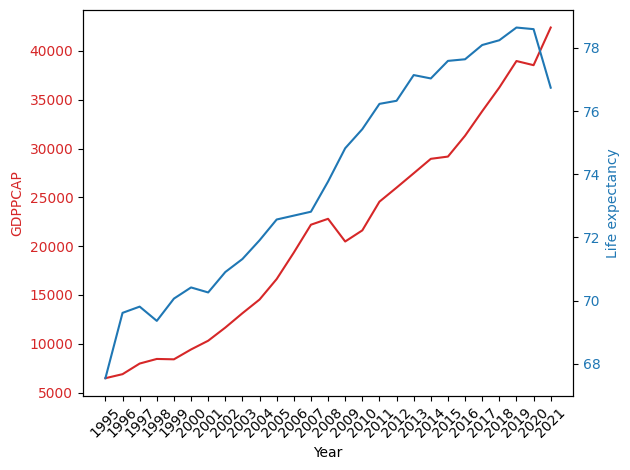

In [152]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('GDPPCAP', color=color)
ax1.plot(df_estonia['Year'], df_estonia['GDPPCAP'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Life expectancy', color=color) 
ax2.plot(df_estonia['Year'], df_estonia['Life expectancy'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()


plt.show()


In [153]:
#Also that to csv file
df_estonia.to_csv('ForPowerBI/df_estonia.csv')